In [1]:
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, Dropout, Activation, Flatten, Dense, Reshape, Conv2DTranspose
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

2022-10-13 23:05:43.405613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 23:05:43.514346: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 23:05:43.949922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-13 23:05:43.949963: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [3]:
class Autoencoder():
    def __init__(
            self,
            input_dim,
            encoder_conv_filters,
            encoder_conv_kernel_size,
            encoder_conv_strides,
            decoder_conv_filters,
            decoder_conv_kernel_size,
            decoder_conv_strides,
            z_dim,
            use_batch_norm=False,
            use_dropout=False
    ):
        self.name = 'autoencoder'
        self.input_dim = input_dim
        self.learning_rate = None

        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides

        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides

        self.z_dim = z_dim
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.layers_encoder_n = len(encoder_conv_filters)
        self.layers_decoder_n = len(decoder_conv_filters)

        self._build()

    def _build(self):
        encoder_input, encoder_output, shape = self._build_encoder()
        self._build_decoder(shape)
        model_output = self.decoder(encoder_output)
        # passes an image through the encoder and back through the decoder to generate a reconstruction
        self.model = Model(encoder_input, model_output)

    def _build_encoder(self):
        encoder_input = Input(shape=self.input_dim, name='encoder_input') # image
        x = encoder_input

        for i in range(self.layers_encoder_n):
            conv_layer = Conv2D(
                filters=self.encoder_conv_filters[i],
                kernel_size=self.encoder_conv_kernel_size[i],
                strides=self.encoder_conv_strides[i],
                padding='same',
                name='encoder_conv2d_' + str(i),
            )
            x = conv_layer(x)
            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate=0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x) # flatten to vector
        encoder_output = Dense(self.z_dim, name='encoder_output')(x) # connect vector to 2D latent space
        # takes an image and encodes it into the 2D latent space
        self.encoder = Model(encoder_input, encoder_output, name='encoder')

        return encoder_input, encoder_output, shape_before_flattening

    def _build_decoder(self, shape):
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        x = Dense(np.prod(shape))(decoder_input)
        x = Reshape(shape)(x)

        for i in range(self.layers_decoder_n):
            conv_layer = Conv2DTranspose(
                filters=self.decoder_conv_filters[i],
                kernel_size=self.decoder_conv_kernel_size[i],
                strides=self.decoder_conv_strides[i],
                padding='same',
                name='decoder_conv2d_' + str(i),
            )
            x = conv_layer(x)

            is_last_iteration = i >= self.layers_decoder_n - 1

            if not is_last_iteration:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)

                x = LeakyReLU()(x)

                if self.use_dropout:
                    x = Dropout(rate=0.25)(x)

            if is_last_iteration:
                x = Activation('sigmoid')(x)

        decoder_output = x
        # takes a point in latent space and decodes it into the original image domain
        self.decoder = Model(decoder_input, decoder_output, name='decoder')

        return decoder_output

    def compile(self, learning_rate):
        self.learning_rate = learning_rate
        optimizer = Adam(learning_rate=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis=[1,2,3])

        self.model.compile(optimizer=optimizer, loss=r_loss)

    def train(self, x_train, batch_size, epochs, lr_decay=1, shuffle=True):
        def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
            def schedule(epoch):
                return initial_lr * (decay_factor ** np.floor(epoch/step_size))
            return LearningRateScheduler(schedule)

        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        self.model.fit(
            x_train,
            x_train,
            batch_size=batch_size,
            shuffle=shuffle,
            epochs=epochs,
            callbacks=[lr_sched]
        )

In [4]:
AE = Autoencoder(
    input_dim=(28, 28, 1),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    decoder_conv_filters=[64, 64, 32, 1],
    decoder_conv_kernel_size=[3, 3, 3, 3],
    decoder_conv_strides=[1, 2, 2, 1],
    z_dim=2,
    use_dropout=True,
    use_batch_norm=True,
)

2022-10-13 23:05:45.160061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:05:45.182046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:05:45.182174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 23:05:45.182563: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
AE.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv2d_0 (Conv2D)   (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 encoder_conv2d_1 (Conv2D)   (None, 14, 14, 64)        18496     
                                                           

In [6]:
AE.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_conv2d_0 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 64)          0   

In [7]:
AE.compile(0.0005)

In [8]:
AE.train(
    x_train[:1000],
    batch_size=32,
    epochs=200,
)

Epoch 1/200


2022-10-13 23:05:47.082994: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


32/32 [==============================] - 2s 7ms/step - loss: 0.1444 - lr: 5.0000e-04
Epoch 2/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0808 - lr: 5.0000e-04
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0685 - lr: 5.0000e-04
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0637 - lr: 5.0000e-04
Epoch 5/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0608 - lr: 5.0000e-04
Epoch 6/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0589 - lr: 5.0000e-04
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0577 - lr: 5.0000e-04
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0565 - lr: 5.0000e-04
Epoch 9/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0559 - lr: 5.0000e-04
Epoch 10/200
32/32 [==============================] - 0s 4ms/step - loss: 0.0553 - lr: 5.0000e-04
Epoch 11/200
32/32 [=====================

1/1 [==============================] - 0s 124ms/step


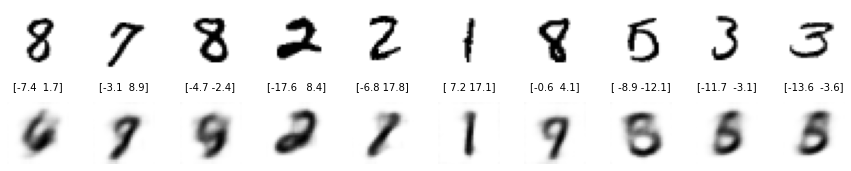

In [9]:
images_to_show = 10
example_images = x_test[
    np.random.choice(range(len(x_test)), images_to_show)
]
z_points = AE.encoder.predict(example_images)
images_reconstructed = AE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(images_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, images_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img, cmap='gray_r')

for i in range(images_to_show):
    img = images_reconstructed[i].squeeze()
    ax = fig.add_subplot(2, images_to_show, i + images_to_show + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')
